In [1]:
from fastai import *
from fastai.vision import *
import torch.nn.functional as F

!pip install git+https://github.com/netbrainml/nbml.git
from nbml.workshops.dog_breed.utils import * 

  Cloning https://github.com/netbrainml/nbml.git to /tmp/pip-req-build-1wo2d92h
  Running command git clone -q https://github.com/netbrainml/nbml.git /tmp/pip-req-build-1wo2d92h
  Created wheel for nbml: filename=nbml-0.0.1-cp36-none-any.whl size=14270 sha256=fe6ee9ea984621b47e9f9c5e5a981314824467c1a1695eed3ca63fc324415781
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7cr46tc/wheels/3a/b1/27/4431be29eb1fbe8f0912364e44fecc078167c19415ed958b11
Successfully built nbml


This function is built from the past transfer learning notebook

In [2]:
base_path = "../input/dog-breed-identification/"
tdl,vdl = load_data(top=20, path=base_path, nc=20)

100%|██████████| 2184/2184 [00:07<00:00, 273.42it/s]


We wrap the DataLoaders in a FastAI Databunch

In [3]:
tdl.c, vdl.c = 20,20
data = ImageDataBunch(tdl, vdl).normalize(imagenet_stats)

Then, we create a Learner, which wraps the data, model, and optimizer.

We have to set our loss function as previously, the loss function does not work.

Also, note we are using mixed precision training, which sets the input data to be half precision, or 16 bits, to promote generalization. However, the gradient calculations are done in 32 bits, which is the normal bits for floating points, as this should be more precise.

Mixed precision training is handled with FastAI

In [4]:
learn = cnn_learner(data, models.resnet34,
                    metrics= [accuracy, error_rate], model_dir="/tmp/model/").to_fp16()
learn.loss_func = F.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.3MB/s]


We can first fine-tuned our model with one cycle policy, which linearly increments and decrements the learning rate while also inversely affecting the momentum
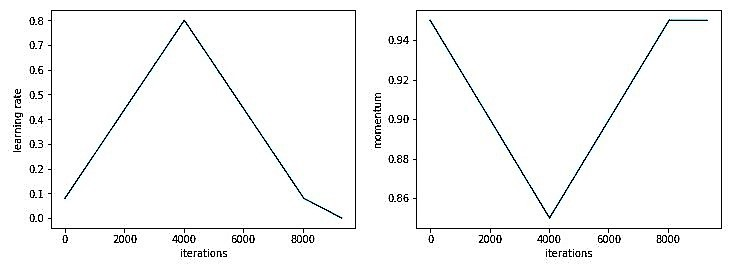

In [5]:
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.372552,3.800517,0.106407,0.893593,00:06
1,3.273289,1.952844,0.426773,0.573227,00:03
2,2.452307,1.506248,0.554920,0.445080,00:03
3,1.929816,1.381632,0.589245,0.410755,00:03
4,1.598431,1.350649,0.588101,0.411899,00:03


Unfreeze our model and use discrimitative learning

In [6]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,3e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.628337,1.210787,0.631579,0.368421,00:05
1,0.422933,1.202139,0.631579,0.368421,00:04
2,0.307496,1.263654,0.649886,0.350114,00:04
3,0.231644,1.255139,0.661327,0.338673,00:04
4,0.182311,1.233136,0.662471,0.337529,00:04


Lets convert our model back, and train it further, to see if it will improve.

In [7]:
learn = learn.to_fp32()
print(list(learn.model[0][0].parameters())[0][0].dtype)

torch.float32


Lets redo the same training.

In [8]:
learn.freeze()
learn.fit_one_cycle(3,1e-4)
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.036738,1.219400,0.663616,0.336384,00:05
1,0.032018,1.211078,0.662471,0.337529,00:03
2,0.030847,1.208193,0.661327,0.338673,00:03


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.030039,1.200982,0.659039,0.340961,00:05
1,0.026384,1.192780,0.660183,0.339817,00:04
2,0.022942,1.188825,0.659039,0.340961,00:04


Lets now resize our data, and train it further

In [9]:
tdl,vdl = load_data(top=20, path=base_path, dim=448, nc=20, bs=40)
tdl.c, vdl.c = 20,20
data = ImageDataBunch(tdl, vdl).normalize(imagenet_stats)

100%|██████████| 2184/2184 [00:08<00:00, 251.29it/s]


In [10]:
learn.data = data
learn.freeze()
learn.fit_one_cycle(3)
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.176651,0.686891,0.782609,0.217391,00:17
1,0.712506,0.687844,0.789474,0.210526,00:15
2,0.429053,0.670187,0.802059,0.197940,00:15


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.187963,0.652761,0.798627,0.201373,00:19
1,0.132232,0.634555,0.814645,0.185355,00:19
2,0.086932,0.627501,0.816934,0.183066,00:19


In [11]:
import gc
del data, tdl, vdl
gc.collect()

75

In [12]:
def acc(pred, Y):
    return (pred==Y.long()).float().mean()

print(acc(learn.get_preds(ds_type=DatasetType.Valid)[1], torch.cat([i[1] for i in learn.data.valid_dl.dl])),
      acc(learn.get_preds(ds_type=DatasetType.Train)[1], torch.cat([i[1] for i in learn.data.train_dl.dl])))

tensor(1.) tensor(1.)


In [13]:
del learn.data
gc.collect()

0

In [14]:
num_classes = 50
tdl,vdl = load_data(top=num_classes, path=base_path, nc=num_classes, bs=40)
tdl.c, vdl.c = num_classes,num_classes
data = ImageDataBunch(tdl, vdl).normalize(imagenet_stats)
gc.collect()

learn.data = data
learn.model[-1][-1] = nn.Linear(512, num_classes, bias=True).cuda()

100%|██████████| 4890/4890 [00:18<00:00, 263.58it/s]


In [15]:
learn.freeze()
learn.fit_one_cycle(5)
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.514777,2.387582,0.495910,0.504090,00:09
1,2.114250,1.601509,0.626789,0.373211,00:08
2,1.338657,1.443755,0.650307,0.349693,00:08
3,0.923209,1.383577,0.663599,0.336401,00:08
4,0.720793,1.371130,0.666155,0.333845,00:08


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.666728,1.340149,0.670245,0.329755,00:11
1,0.518786,1.298806,0.676892,0.323108,00:11
2,0.328550,1.276051,0.688139,0.311861,00:11
3,0.214254,1.264342,0.692740,0.307260,00:11
4,0.163453,1.264992,0.693252,0.306748,00:11
